In [1]:
import pandas as pd
import numpy as np
import gmpy2 as gm
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tqdm import trange
import pydotplus
from IPython.display import Image
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import matplotlib.patches as mpatches
import pygraphviz as graphviz
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches
import math
import torch as tc
import torch.nn as nn
import wandb
import os

In [2]:
%env WANDB_API_KEY=1d1e623d83b5eca3c652c153aa3332013efa2c68


env: WANDB_API_KEY=1d1e623d83b5eca3c652c153aa3332013efa2c68


In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tararu. Use `wandb login --relogin` to force relogin


True

In [4]:
def digit_root(n): 
    return (n - 1) % 9 + 1

In [5]:
def perfect_square(x):
    if gm.is_square(x):
        return np.sqrt(x)

In [6]:
def magnitude(x):
    return int(math.floor(math.log10(x)))

'''The simplest answer is that D(137) + D(7) = D(144). 
in other words, if i send the digital root of the number x, D(x), and its distance to the nearest 
(larger) perfect square, delta,, then the digital root of the nearest perfect square is just D(x) + D(delta)

we can use a local snap shot + ML to identify digital root instead of converting number to string. 
'''

In [7]:
def droot_ps(x):
    x_plus=[]
    x_minus = []
    for i in np.arange(x):
        x_p = x+i
        x_m = x-i
        if gm.is_square(int(x_p)):
            x_plus.append(x_p)
        if gm.is_square(int(x_m)):
            x_minus.append(x_m)
        if (len(x_plus) >= 1 & len(x_minus) >=1):
            break
    
    diff_plus = x_plus[0]-x
    diff_minus = x-x_minus[0]
    D_p = digit_root(x_plus[0])
    D_m = digit_root(x_minus[0])
    D_x = digit_root(x)
    Ddp = digit_root(diff_plus)
    Ddm = digit_root(diff_minus)
    Order = magnitude(x)
    return (x, D_x, Order, x_plus, D_p, diff_plus, Ddp, x_minus, D_m, diff_minus, Ddm)
            

In [8]:
droot_ps(2178)

(2178, 9, 3, [2209], 4, 31, 4, [2116], 1, 62, 8)

In [9]:
result = []
range = np.arange(10,1000)
for x in range:
    result.append(droot_ps(x))

result[:5]
    

[(10, 1, 1, [16], 7, 6, 6, [9, 4, 1], 9, 1, 1),
 (11, 2, 1, [16], 7, 5, 5, [9], 9, 2, 2),
 (12, 3, 1, [16], 7, 4, 4, [9], 9, 3, 3),
 (13, 4, 1, [16], 7, 3, 3, [9], 9, 4, 4),
 (14, 5, 1, [16], 7, 2, 2, [9], 9, 5, 5)]

In [10]:
df = pd.DataFrame(result, columns=['x', 'D_x', 'O', 'P', 'D_P', 'd_P', 'D_d_P', 'N', 'D_N', 'd_N', 'D_d_N'])

In [11]:
# Plotting the numbers vs the ratio of the number to the positive/negative distance along with D_root of the number. 
data=[go.Scatter(x=[x[0] for x in result], y=[x[3][0]/x[0] for x in result], mode='markers', name='pos_ratio'),
      go.Scatter(x=[x[0] for x in result], y=[x[0]/x[7][0] for x in result], mode='markers',name = 'neg_ratio',marker = dict(symbol = 'pentagon')),
      go.Scatter(x=[x[0] for x in result], y=[x[1]/10 for x in result], mode='markers', name='D_number')]
fig = go.Figure(data)
fig.show()


In [12]:
# for numbers whose digital roots are 5 or 8, they can't be equidistance from their positive and negative next PSN.
from itertools import compress
crit = [x[3][0]/x[0] == x[0]/x[7][0] for x in result]
list(compress(result, crit))[:20];

In [13]:
#Plotting the distance difference for positive and negative PSN ratios: P/x - x/N
data=[go.Scatter(x=[x[0] for x in result], y=[(x[3][0]/x[0])-(x[0]/x[7][0]) for x in result], mode='markers')]
      #go.Scatter(x=[x[0] for x in result], y=[x[1]/10 for x in result], mode='markers',)]
fig = go.Figure(data)
fig.show()

In [14]:
#Plotting the distance difference for positive and negative PSN ratios: P/x - x/N
data=[go.Scatter(x=[x[0] for x in result], y=[((x[3][0]-x[7][0]))/x[0] for x in result], mode='markers')]
      #go.Scatter(x=[x[0] for x in result], y=[x[1]/10 for x in result], mode='markers',)]
fig = go.Figure(data)
fig.show()

In [15]:
#Plot of vs the difference between postive and negative distance d_P - d_N
data=[go.Scatter(x=[x[0] for x in result], y=df.d_P-df.d_N , mode='markers')]
      #go.Scatter(x=[x[0] for x in result], y=[x[1]/10 for x in result], mode='markers',)]
fig = go.Figure(data)
fig.show()

In [16]:
#Plot of vs the difference between the digital root of postive and negative distance D_d_P - D_d_N
data=[go.Scatter(x=[x[0] for x in result], y=df.D_d_P-df.D_d_N , mode='markers')]
      #go.Scatter(x=[x[0] for x in result], y=[x[1]/10 for x in result], mode='markers',)]
fig = go.Figure(data)
fig.show()

In [17]:
# plot of the digital root of the number x divided by the digital root of the ditance to the positive PSN
data=[go.Scatter(x=[x[0] for x in result], y=[(x[1]/x[5]) for x in result], mode='markers')]
fig = go.Figure(data)
fig.show()

C:\Users\gtala\AppData\Local\Temp\ipykernel_12032\3671206113.py:2: RuntimeWarning:

divide by zero encountered in long_scalars



In [18]:
# plot of the digital root of the number x divided by the digital root of the ditance to the negative PSN

data=[go.Scatter(x=[x[0] for x in result], y=[(x[1]/x[9]) for x in result], mode='markers')]
fig = go.Figure(data)
fig.show()

C:\Users\gtala\AppData\Local\Temp\ipykernel_12032\3740806235.py:3: RuntimeWarning:

divide by zero encountered in long_scalars



In [19]:
#plot for the digital roots of the number x, its postive distance D_d_P and negative distance D_d_N
range=range[:100]
data = [go.Scatter(x=range, y = [z[5] for z in result[:100]],mode='markers', name='diff_Plus'), 
        go.Scatter(x=range, y = [z[9]for z in result[:100] ],mode='markers' , name='diff_Minus'), 
        go.Scatter(x=range, y = [z[1]for z in result[:100] ],mode='markers', marker = dict( size =12,  color = 'rgb(54, 103, 245)', symbol = 'pentagon', line = {'width':2}),name='D_number')] 
layout = go.Layout()
fig = go.Figure(data)
fig.show()

In [7]:
RFC = RandomForestClassifier()
NB = CategoricalNB()
LR = LogisticRegression()
GNB = GaussianNB()
svc= SVC
ABC = AdaBoostClassifier()
MLP = MLPClassifier(max_iter=1000)

# Pytorch

In [7]:
import torch as tc
import string
import random
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR, ExponentialLR
import gc
# Utils
from tqdm import tqdm
from collections import defaultdict
import time
import copy
# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL




In [8]:

tc.cuda.is_available()

True

### Set Seed for Reproducibility

In [9]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in np.arange(size))

HASH_NAME = id_generator(size=12)
print(HASH_NAME)

pvu6k5sxmgam


In [73]:
CONFIG = {"seed": 2022,
          "epochs": 250,
          "model_name": "square_predict",
          "train_batch_size": 32,
          "valid_batch_size": 64,
          "learning_rate":0.008,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 2,
          "n_accumulate": 1,
          "num_classes": 1,
          "margin": 0.5,
          "device": tc.device("cuda:0" if tc.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "layers": [1000, 1000]
          }


CONFIG['group'] = f'{HASH_NAME}-Baseline'

In [55]:
CONFIG['layers'][0]

2000

In [56]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    tc.manual_seed(seed)
    tc.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    tc.backends.cudnn.deterministic = True
    ''' This is set to make sure that we get the same exact result for every similar run '''
    tc.backends.cudnn.benchmark = True 
    '''It enables benchmark mode in cudnn.benchmark mode is good whenever input sizes for the network do not vary. This way, cudnn will look for the optimal set of algorithms 
        for that particular configuration (which takes some time). This usually leads to faster runtime. But if input sizes changes at each iteration, 
        then cudnn will benchmark every time a new size appears, possibly leading to worse runtime performances.'''
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

### Data Reading and Feature Engineering

result = []
range = trange(100000,500000)
for x in range:
    result.append(droot_ps(x))

result[:5]

In [57]:
#df = pd.DataFrame(result, columns=['x', 'D_x', 'O','P', 'D_P', 'd_P', 'D_d_P', 'N', 'D_N', 'd_N', 'D_d_N'])
#df['P'] = df["P"].apply(lambda x: x[0])
#df['N'] = df["N"].apply(lambda x: x[0])
#df.to_csv('sqaure_pred_100K-500K.csv', )
df= pd.read_csv('sqaure_pred_100K-500K.csv', index_col = None)

In [58]:
df = df.sample(frac=1)


In [59]:
cat_cols = ['D_x', 'D_d_P', 'D_P']
cont_cols = ['d_P', 'O']
y_col = ['P']

In [60]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

df['D_x'].cat.categories
df['D_x'].cat.codes;

D_x= df['D_x'].cat.codes.values
D_d_P = df['D_d_P'].cat.codes.values
D_P = df['D_P'].cat.codes.values

In [61]:
cats = np.stack([D_x,D_d_P,D_P],1)
cats

array([[4, 7, 1],
       [8, 8, 3],
       [4, 1, 2],
       ...,
       [2, 5, 3],
       [3, 4, 3],
       [6, 8, 2]], dtype=int8)

In [62]:
#cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)
cont = np.stack([df[col].values for col in cont_cols], 1)
cont = tc.tensor(cont, dtype=tc.float32).cuda()
cats = tc.tensor(cats, dtype=tc.int64).cuda()
y=tc.tensor(df[y_col].values, dtype=tc.float).reshape(-1, 1).cuda()
cats.shape, cont.shape, y.shape

(torch.Size([400000, 3]), torch.Size([400000, 2]), torch.Size([400000, 1]))

In [63]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(9, 5), (9, 5), (4, 2)]

In [64]:
batch_size = len(df)
test_size = int(batch_size * .3)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = cont[:batch_size-test_size]
con_test = cont[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]
len(cat_train), len(cat_test)

(280000, 120000)

In [74]:
class PSN(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.4,):
        super(PSN, self).__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        #self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            #layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = tc.cat(embeddings, 1)
        #x = self.emb_drop(x)
        
        #x_cont = self.bn_cont(x_cont)
        x = tc.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [75]:
tc.manual_seed(20)
model = PSN(emb_szs, cont.shape[1], 1, CONFIG['layers'], p=0.4).cuda()
model

PSN(
  (embeds): ModuleList(
    (0): Embedding(9, 5)
    (1): Embedding(9, 5)
    (2): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=14, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=1000, out_features=1000, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=1000, out_features=1, bias=True)
  )
)

In [76]:
criterion = nn.MSELoss()
optimizer = tc.optim.Adam(model.parameters(), lr = CONFIG['learning_rate'])


In [77]:
wandb.init(project="compression-project", 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     name=f'{HASH_NAME}',
                     anonymous='must',
                     );
'''wandb.config = {
  "learning_rate": 0.003,
  "epochs": 300,
  
}'''

loss,▅▃▄▆▆▂▅▁▅▄▄▅▄▄▃▅▄▂▆▄▅▂▄▂▆▂█▆▆▅▁▆▃▆▄▃▅▁▃▇
loss,107192.16406


'wandb.config = {\n  "learning_rate": 0.003,\n  "epochs": 300,\n  \n}'

In [78]:
import time
start_time = time.time()

epochs = CONFIG['epochs']
losses = []

for i in np.arange(epochs):
    wandb.watch(model)
    i+=1
    y_pred = model(cat_train, con_train)
    loss = tc.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss.item())
    wandb.log({"loss": loss})
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    #scheduler.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 322074.53125000
epoch:  26  loss: 171410.85937500
epoch:  51  loss: 154629.65625000
epoch:  76  loss: 120617.01562500
epoch: 101  loss: 108935.59375000
epoch: 126  loss: 107669.25000000
epoch: 151  loss: 107443.89062500
epoch: 176  loss: 107344.88281250
epoch: 201  loss: 107378.87500000
epoch: 226  loss: 107388.33593750
epoch: 250  loss: 107344.77343750

Duration: 32 seconds


In [23]:
with tc.no_grad():
    y_val = model(cat_test, con_test)
    loss = tc.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')


RMSE: 122503.57031250


In [ ]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in np.arange(1, 50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

# Using Data Loader

In [141]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR, ExponentialLR

In [142]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in np.arange(size))

HASH_NAME = id_generator(size=12)
print(HASH_NAME)

stra7h633ank


In [155]:
CONFIG = {"seed": 2022,
          "epochs": 150,
          "model_name": "square_predict",
          "train_batch_size": 32,
          "valid_batch_size": 64,
          "max_length": 128,
          "learning_rate":0.01,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 2,
          "n_accumulate": 1,
          "num_classes": 1,
          "margin": 0.5,
          "device": tc.device("cuda:0" if tc.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME
          }


CONFIG['group'] = f'{HASH_NAME}-Baseline'

In [144]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    tc.manual_seed(seed)
    tc.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    tc.backends.cudnn.deterministic = True
    ''' This is set to make sure that we get the same exact result for every similar run '''
    tc.backends.cudnn.benchmark = True 
    '''It enables benchmark mode in cudnn.benchmark mode is good whenever input sizes for the network do not vary. This way, cudnn will look for the optimal set of algorithms 
        for that particular configuration (which takes some time). This usually leads to faster runtime. But if input sizes changes at each iteration, 
        then cudnn will benchmark every time a new size appears, possibly leading to worse runtime performances.'''
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [145]:
skf = StratifiedKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG['seed'])

for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.P)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)
df.head()

,x,D_x,O,P,D_P,d_P,D_d_P,N,D_N,d_N,D_d_N,kfold
373201,473201,8,5,473344,7,143,8,471969,9,1232,8,1
382098,482098,4,5,483025,4,927,9,481636,1,462,3,0
267480,367480,1,5,368449,7,969,6,367236,9,244,1,1
7219,107219,2,5,107584,7,365,5,106929,9,290,2,1
218995,318995,8,5,319225,4,230,5,318096,9,899,8,0


In [146]:
class PSN_data(Dataset):
    def __init__(self, df):
        self.df = df
        self.cat_cols = ['D_x', 'D_d_P', 'D_P']
        self.cont_cols = ['d_P', 'O']
        self.y_col = ['P']
        
        
        for cat in self.cat_cols:
            df[cat] = df[cat].astype('category')
        
        
        '''  self.cats = cats
        self.cont = cont
        self.y = y'''
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index=None):
        
        D_x= df['D_x'].cat.codes.values
        D_d_P = df['D_d_P'].cat.codes.values
        D_P = df['D_P'].cat.codes.values
        
        cat_szs = [len(df[col].cat.categories) for col in self.cat_cols]
        emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
        
        
        cats = np.stack([D_x,D_d_P,D_P],1) #[index]
        cont = np.stack([df[col].values for col in self.cont_cols], 1) #[index]
        y = df[self.y_col].to_numpy() #[index]
        
        
        cont = tc.tensor(cont, dtype=tc.float32).cuda()
        cats = tc.tensor(cats, dtype=tc.int64).cuda()
        y=tc.tensor(y, dtype=tc.float).reshape(-1, 1).cuda()
        '''cats = self.cats[index]
        cont = self.cont[index]
        y = self.y[index]'''
        
        
        #return {'cats': cats, 'cont': cont, 'y': y, 'emb_szs': emb_szs}
        return [cats, cont, y, emb_szs]

In [147]:
emb_szs = PSN_data(df).__getitem__()[3]
emb_szs

[(9, 5), (9, 5), (4, 2)]

In [148]:
class PSN(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.4,):
        super(PSN, self).__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        #self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            #layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = tc.cat(embeddings, 1)
        #x = self.emb_drop(x)
        
        #x_cont = self.bn_cont(x_cont)
        x = tc.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

## Define loss function & optimizer

In [149]:
criterion = nn.MSELoss()
#optimizer = tc.optim.Adam(model.parameters(), lr = 0.1)
#scheduler = StepLR(optimizer, 'min', )

## Data Loader Function

In [150]:
def prepare_loaders(fold):
    

    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = PSN_data(df_train, )
    valid_dataset = PSN_data(df_valid, )

    train_loader = train_dataset
    valid_loader = valid_dataset
    '''train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True,)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True, )'''
    
    return train_loader, valid_loader

# Optimizer Scheduler

In [151]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
  
    
    elif CONFIG['scheduler'] == None:
        return None
    return scheduler

# Training Function

In [152]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    #bar = tqdm(iter(dataloader), total=len(dataloader))
    #step = [x for x, data in bar]
    #for step, data in bar:
    data = dataloader
    for i in tqdm(np.arange(epoch)):
        cat_train = data[0][0]
        con_train = data[0][1]
        y_train = data[0][2]
        batch_size = con_train.shape[0]

        y_pred = model(cat_train, con_train)
        
        loss = criterion(y_pred, y_train)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()

        
        #if (step + 1) % CONFIG['n_accumulate'] == 0:
        optimizer.step()

        # zero the parameter gradients
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()
                    
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
            
        epoch_loss = running_loss / dataset_size
            
            #bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return np.sqrt(epoch_loss)

model = PSN(emb_szs, 2, 1, [200, 100], p=0.4).cuda()
trainloader = prepare_loaders(fold)
optimizer = tc.optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler=fetch_scheduler(optimizer)
train_one_epoch(model, optimizer, scheduler=scheduler, dataloader =train_loader, device = CONFIG['device'], epoch=300)

## Validation Function

In [153]:
@tc.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    #bar = tqdm(enumerate(dataloader), total=len(dataloader))
    data = dataloader
    for i in tqdm(np.arange(epoch)):      
        cat_valid = data[0][0]
        con_valid = data[0][1]
        y_valid = data[0][2]
        batch_size = con_valid.shape[0]
        y_pred = model(cat_valid, con_valid)
        
        loss = criterion(y_pred, y_valid)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        #bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return np.sqrt(epoch_loss)

## Run Training

In [156]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if tc.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(tc.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in np.arange(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        
        print()
        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            #run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"Loss-Fold-{fold}.bin"
            tc.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [ ]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='square_predict', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=['roberta-base', f'{HASH_NAME}', 'margin-loss'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold)
    
    model = PSN(emb_szs, 2, 1, [200, 100, 100], p=0.4).cuda()
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = tc.optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler =None,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

RMSE: 109201.58593750


In [ ]:
X_cat = X[['D_x', 'D_d_P', 'D_P']]
X_cont = X[['O', 'd_P']]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=15,)

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Logistic Regression
LR.fit(X_train, y_train)
LR.predict(X_test);
accuracy_score(y_test, LR.predict(X_test))

c:\Users\gtala\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.044282681225356384

In [ ]:
# Multi Layer Perceptrons

MLP.fit(X_train, y_train)
accuracy_score(y_test, MLP.predict(X_test))

0.06521079769487413

In [ ]:
#Guassian Naive Baise
GNB.fit(X_train, y_train)
accuracy_score(y_test, GNB.predict(X_test))

0.023961176827418867

In [ ]:
#Adaboost
ABC.fit(X_train, y_train)
accuracy_score(y_test, ABC.predict(X_test))

0.14134061267819228

In [ ]:
#Random Forest Classifier
RFC.fit(X_train, y_train)
accuracy_score(y_test, RFC.predict(X_test))

0.021534728541097968

In [ ]:
DTC = DecisionTreeClassifier(min_samples_split=2, criterion='gini').fit(X_train, y_train)
accuracy_score(y_test, DTC.predict(X_test))

0.021534728541097968

In [ ]:
print(confusion_matrix(y_test, DTC.predict(X_test)))

[[ 7367     0     0     2]
 [    1  7291     0     0]
 [    0     0  7312     4]
 [    6     0     0 11014]]


In [ ]:
data = [go.Scatter(x = df.x, y=df.D_x, name='D(x)'),
        go.Scatter(x = df.x, y=df.d_P, name='d_p'),]
        #go.Scatter(x = df_result.x, y=df_result.D_P, name='D_p'),]
fig = go.Figure(data)
fig.show()

In [ ]:
data = [go.Scatter(x = df.d_P[:100], y=df.D_x[:100], name='D(x)', mode='markers+lines')]
    
fig = go.Figure(data)
#fig.show()

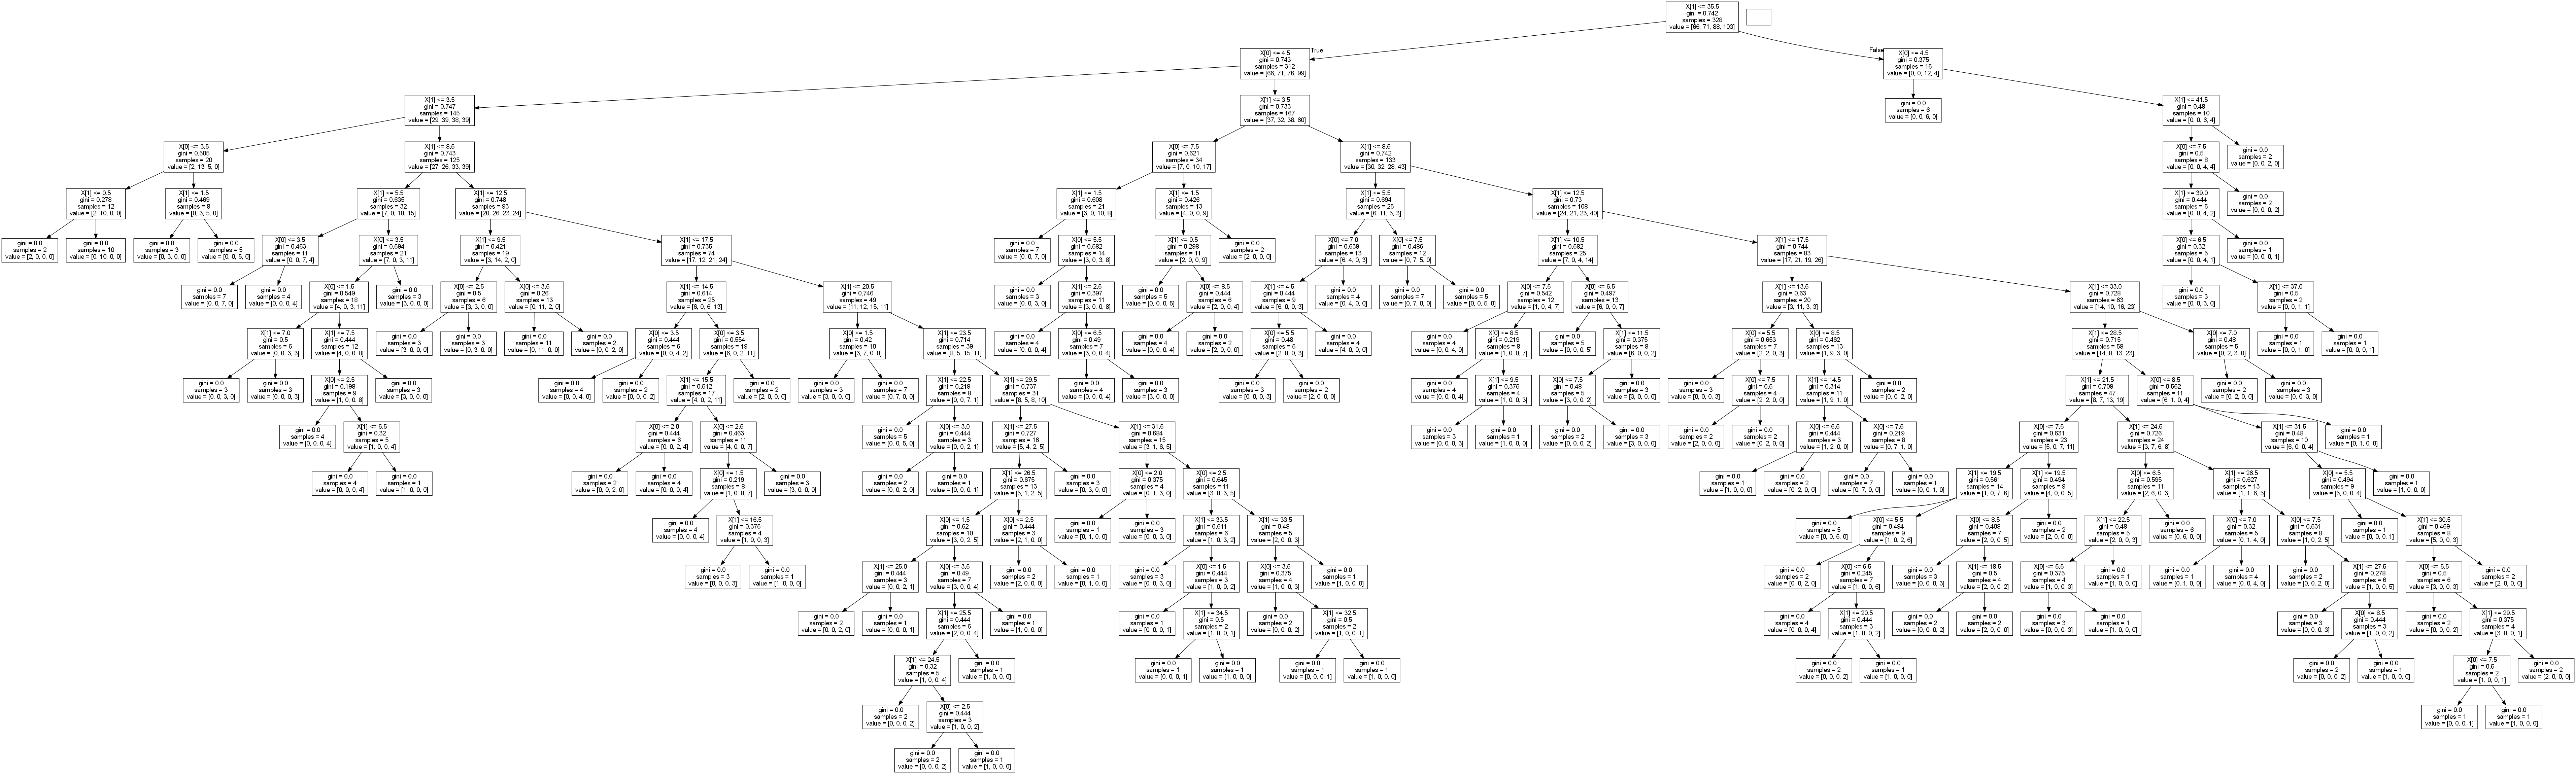

In [ ]:
dt = DTC.fit(X_train,y_train)
dt_graphviz = export_graphviz(dt, out_file = None)
pydot_graph = pydotplus.graph_from_dot_data(dt_graphviz)
Image(pydot_graph.create_png())

In [ ]:
y_test.unique()

array([7, 1, 9, 4])

In [ ]:
df_ = pd.DataFrame(np.array([[4, 42]]), columns = ['D_x', 'd_P'])
RFC.predict(df_)

array([1])

In [ ]:
x = 25879
digit_root(x)

4

In [ ]:
sqrt = np.sqrt(x)
int(sqrt)

160

In [ ]:
y = int(sqrt+1)**2
y

25921

In [ ]:
digit_root(y)

1

In [ ]:
x-y

-42